# Prepare Lauritzen Blocks

Make cutout from one of the lauritzen blocks and store it in cremi format for bigcat.

Prerequisites to run this notebook:
Besides standard python packages, we will need vigra, nifty and z5py to run the code.
The easiest way to install it is in a clean conda environment:

`conda create -n fix-cremi -c conda-forge -c cpape python=3.6 z5py jupyter vigra h5py`

`source activate fix-cremi`

In [1]:
# import all necessary packages
# this might throw a runtime error, that can be ignored 
import sys
import numpy as np
import h5py
import z5py
import vigra

## Create output file

As input data, we assum an N5 container, containing raw data, watershed-fragments nd
fragment to segment assignment.

The notebook will produce a HDF5 file with raw data, fragments and look-up table from segments to 
projected groundtruth segments, to be ingested by bigcat.
Cut to a specified bounding box.

In [66]:
# calculate the center bounding box
def find_bounding_box(path, key, halo):
    # load the mask that indicates labeled parts of the data
    shape = z5py.File(path)[key].shape
    bb = tuple(slice(max(sh // 2 - ha, 0),
                     min(sh // 2 + ha, sh)) for sh, ha in zip(shape, halo))
    return bb

In [67]:
# specifiy all relevant paths
# for this example we use the mala training data,
# change paths for the actual test data accordingly

# the sample we will process
block_id = 2

# path and key to the cremi h5 file with groundtruth, raw data and groundtruth mask
path = '/home/papec/mnt/nrs/lauritzen/0%i/workspace.n5/raw/' % block_id
key_raw = 'gray'
key_ws = 'segmentations/watershed2'
key_assignment = 'node_labelings/mc_glia_global2'

# the path to the output h5 file
path_out = '/home/papec/mnt/papec/lauritzen_block%i_20microns.h5' % block_id
key_fragments = 'volumes/labels/fragments'

# get the relevant bounding box
# halo = (125, 1250, 1250) # 5 micron halo -> 10 micron cutout
halo = (250, 2500, 2500) # 10 micron halo -> 20 micron cutout
bb = find_bounding_box(path, key_raw, halo)
print(bb)

(slice(0, 500, None), slice(714, 5714, None), slice(475, 5475, None))


In [68]:
# create the output dataset and copy the raw data
def create_output_file(in_path, out_path, in_key, out_key, bounding_box):
    # check if we have the raw data in our out file already
    with h5py.File(out_path) as f:
        have_raw = out_key in f
    
    # if we do, we don't need to do anything here
    if have_raw:
        return
    
    # otherwise, load the raw data and write it to the out file
    with z5py.File(in_path) as f:
        ds_raw = f[in_key]
        ds_raw.n_threads = 8
        raw = ds_raw[bounding_box]
    
    offset = tuple(b.start for b in bounding_box)
    resolution = [40., 4., 4.]
    with h5py.File(out_path) as f:
        ds = f.create_dataset(out_key, data=raw, compression='gzip')
        ds.attrs['resolution'] = resolution
        ds.attrs['offset'] = [0., 0., 0.]
        # offset in original file (in nm)
        f.attrs['global_offset'] = [off * res for off, res in zip(offset, resolution)]
        # bigcat format
        f.attrs['file_format'] = 0.2

In [69]:
create_output_file(path, path_out, key_raw, 'volumes/raw', bb)

## Save watershed fragments

Save the watershed fragments and the fragment to segment assignment.

In [70]:
def save_watersheds(in_path, out_path, in_key, out_key, bounding_box):
    
    # we load the fragments
    # NOTE we do note perform connected components, as ths would
    # break the fragment to segment assignment
    with z5py.File(in_path) as f:
        ds_ws = f[in_key]
        ds_ws.n_threads = 8
        ws = ds_ws[bounding_box].astype('uint64')
    fragment_ids = np.unique(ws)
    
    # check if the watersheds were saved already
    with h5py.File(out_path) as f:
        have_ws = out_key in f    
    if have_ws:
        return fragment_ids

    # otherwise write to the out file
    resolution = [40., 4., 4.]
    with h5py.File(out_path) as f:
        ds = f.create_dataset(out_key, data=ws, compression='gzip')
        ds.attrs['resolution'] = resolution
        ds.attrs['offset'] = [0., 0., 0.]
    
    return fragment_ids

In [71]:
fragment_ids = save_watersheds(path, path_out, key_ws, key_fragments, bb)

MemoryError: 

In [61]:
# plot a slice of raw data overlaid with the fragments (or any other segmentation)
def plot_segmentation(path, raw_key, fragments_key,
                      slice_id=0, alpha=0.6,
                      assignments=None):
    import matplotlib.pyplot as plt
    from skimage import img_as_float, color
    
    # load the slice from the raw data
    with h5py.File(path) as f:
        raw_im = f[raw_key][slice_id]
        frag_im = f[fragments_key][slice_id]
        
    # apply assignments if we have them
    # FIXME this is pretty in-efficient
    if assignments is not None:
        frag_ids = np.unique(frag_im)
        for frag_id in frag_ids:
            frag_im[frag_im == frag_id] = assignments[frag_id]
    
    # relabel this slice to make our live easier
    vigra.analysis.relabelConsecutive(frag_im, out=frag_im,
                                      start_label=1, keep_zeros=True)
    
    # convert the grayscale raw data to rgb
    im = img_as_float(raw_im)
    img_color = np.dstack((im, im, im))
    # create random colors for fragments
    
    n_fragments = int(frag_im.max()) + 1
    random_colors = np.random.rand(n_fragments, 3)
    
    # create the color mask
    color_mask = np.zeros_like(img_color)
    # we skip 0 (ignore label)
    for frag_id in range(1, n_fragments):
        color_mask[frag_im == frag_id, :] = random_colors[frag_id]
    
    # convert raw and fragments to hsv images
    im_hsv = color.rgb2hsv(img_color)
    mask_hsv = color.rgb2hsv(color_mask)
    
    # replace hue and saturation of the raw data
    # with that of color mask
    im_hsv[..., 0] = mask_hsv[..., 0]
    im_hsv[..., 1] = mask_hsv[..., 1] * alpha
    
    im_colored = color.hsv2rgb(im_hsv)
    f, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im_colored)
    plt.show()

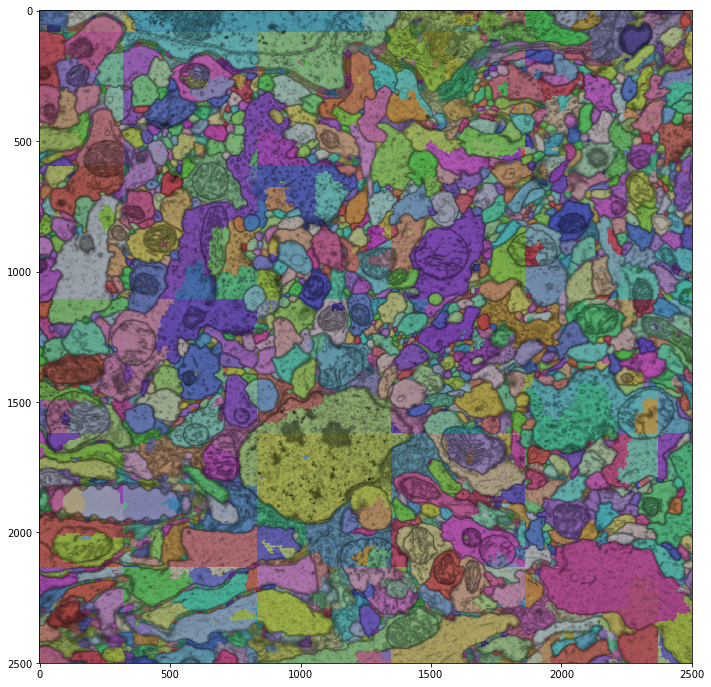

In [37]:
# plot the fragments for one slice
plot_segmentation(path_out, 'volumes/raw', key_fragments, slice_id=0)

## Save segment assignment

Save the fragment to segment assignment produced by the multicut.

In [57]:
def save_assignments(in_path, in_key, out_path, out_key, ids):
    # load the assignments 
    with z5py.File(in_path) as f:
        assignments = f[in_key][:]
        
    # we only need the assignments of the ids that are present in our
    # bounding box
    # (the assignments are saved consecutively, so we can simply index here)
    ids = ids.astype('uint64')
    assignments = assignments[ids].astype('uint64')

    # add the number of fragments as offset to the assignments, because
    # in bigcat fragment ids are also segment ids
    n_fragments = int(ids[-1] + 1)

    assignments += n_fragments
    # find the next valid segment id
    next_id = int(assignments.max() + 1)

    # build the correct lut format for bigcat
    lut = np.array([(frag_id, seg_id)
                    for frag_id, seg_id in zip(ids, assignments)],
                   dtype='uint64')
    lut = lut.transpose()
    
    # make an assignment dictionary for later visualisation
    assignment_dict = {frag_id: seg_id for frag_id, seg_id in zip(ids, assignments)}
    
    # check if the assignments are already saved, otherwise save them
    with h5py.File(out_path) as f:
        if out_key in f:
            return assignment_dict
        f.create_dataset(out_key, data=lut, chunks=True, maxshape=(2, None))
        f.attrs['next_id'] = int(next_id)
    
    return assignment_dict

In [58]:
# get the segment to fragment lut
assignment_dict = save_assignments(path, key_assignment, path_out, 'fragment_segment_lut', fragment_ids)

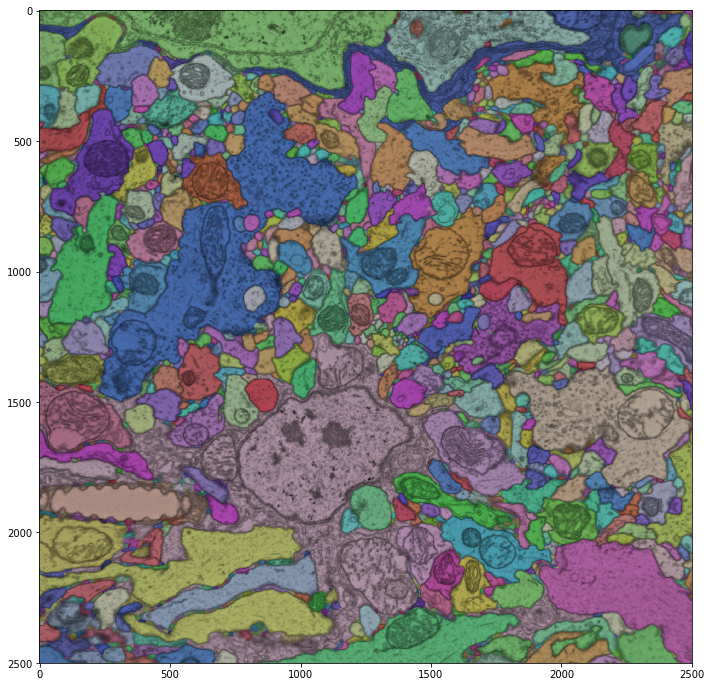

In [63]:
# plot the fragments with assignments for one slice
plot_segmentation(path_out, 'volumes/raw', key_fragments, slice_id=0,
                  assignments=assignment_dict)